<a href="https://colab.research.google.com/github/encinas88/Medical-Classifier/blob/master/medicalP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

Download dataset from Kaggle

In [0]:
os.environ['KAGGLE_USERNAME']= 'encinas88'
os.environ['KAGGLE_KEY']= 'fcc8ec596653e52a3f204534e5e93d93'

In [27]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


unzip files dataset

In [0]:
!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

Archive:  chest-xray-pneumonia.zip
replace chest_xray.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

DATA preview using training and test images from kaggle

In [0]:
training_dir = './chest_xray/train'
validation_dir = './chest_xray/test'
test_dir = './chest_xray/val'

training image picked

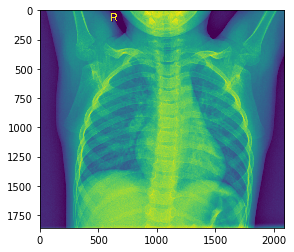

In [30]:
img = mpimg.imread(training_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

Plotting images 

In [0]:
def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12,6))
  
  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break
      
      img = mpimg.imread(os.path.join(path,file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)
    
      amount +=1

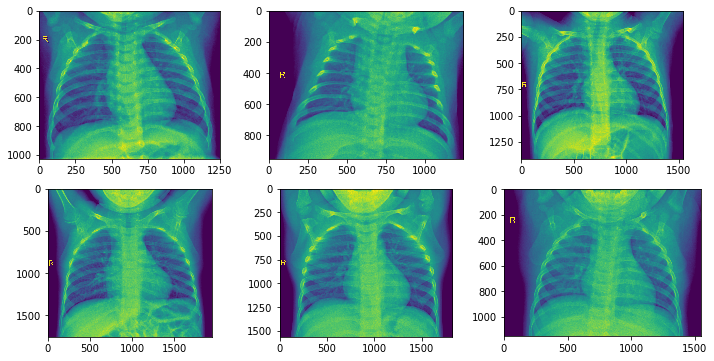

In [32]:
plot_images(training_dir + '/NORMAL')

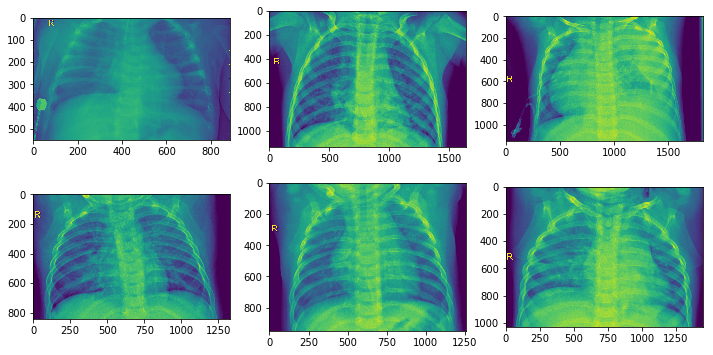

In [33]:
plot_images(training_dir + '/PNEUMONIA')

Train model using tensorflow backend

In [34]:
rescale = 1./255.0
target_size = (100,100)
batch_size = 20
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)
validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)
test_datagen= ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
def get_model():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x=base_model.output
  x=keras.layers.GlobalAveragePooling2D()(x)
  x=keras.layers.Dense(1024, activation='relu')(x)
  x=keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(2, activation='softmax')(x)
  model=keras.models.Model(input=base_model.inputs, outputs=predictions)
  
  for layer in base_model.layers:
    layer.trainable = False
    
  model.summary()
  return model


In [36]:
model = get_model()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_191 (BatchN (None, None, None, 3 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, None, None, 3 0           batch_normalization_191[0][0]    
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`
  


In [37]:
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/5
261/261 [==============================] - 90s 345ms/step - loss: 0.5768 - acc: 0.7651 - val_loss: 1.5380 - val_acc: 0.6603
Epoch 2/5
261/261 [==============================] - 78s 299ms/step - loss: 0.4290 - acc: 0.8163 - val_loss: 1.8242 - val_acc: 0.5208
Epoch 3/5
261/261 [==============================] - 80s 308ms/step - loss: 0.4050 - acc: 0.8183 - val_loss: 2.0086 - val_acc: 0.6458
Epoch 4/5
261/261 [==============================] - 78s 301ms/step - loss: 0.3964 - acc: 0.8263 - val_loss: 0.9464 - val_acc: 0.7212
Epoch 5/5
261/261 [==============================] - 81s 309ms/step - loss: 0.3778 - acc: 0.8303 - val_loss: 0.7610 - val_acc: 0.7308


Review Model 

In [38]:
result= model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print('Loss:', result[0])
print('Accuracy:', result[1])

16/16 [==============================] - 1s 70ms/step
Loss: 0.593344186350123
Accuracy: 0.625


In [39]:
y_pred_batches = []
y_true_batches = []

for i in range(0, len(test_generator)):
  y_img_batch, y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_true_batches.append(y_true_batch)
  
  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)
  
  print(y_pred_batches)

[array([0])]
[array([0]), array([0])]
[array([0]), array([0]), array([0])]
[array([0]), array([0]), array([0]), array([1])]
[array([0]), array([0]), array([0]), array([1]), array([1])]
[array([0]), array([0]), array([0]), array([1]), array([1]), array([1])]
[array([0]), array([0]), array([0]), array([1]), array([1]), array([1]), array([0])]
[array([0]), array([0]), array([0]), array([1]), array([1]), array([1]), array([0]), array([0])]
[array([0]), array([0]), array([0]), array([1]), array([1]), array([1]), array([0]), array([0]), array([0])]
[array([0]), array([0]), array([0]), array([1]), array([1]), array([1]), array([0]), array([0]), array([0]), array([1])]
[array([0]), array([0]), array([0]), array([1]), array([1]), array([1]), array([0]), array([0]), array([0]), array([1]), array([1])]
[array([0]), array([0]), array([0]), array([1]), array([1]), array([1]), array([0]), array([0]), array([0]), array([1]), array([1]), array([1])]
[array([0]), array([0]), array([0]), array([1]), arr

In [0]:
def predict_images(images_path, label):
  amount = 0
  fig = plt.figure(figsize=(18, 8))
  
  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if amount == 8:
        break
        
      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(241+amount)
      plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[amount]== 0 else 'PNEUMONIA'))
      imgplot = plt.imshow(img)
      
      amount +=1

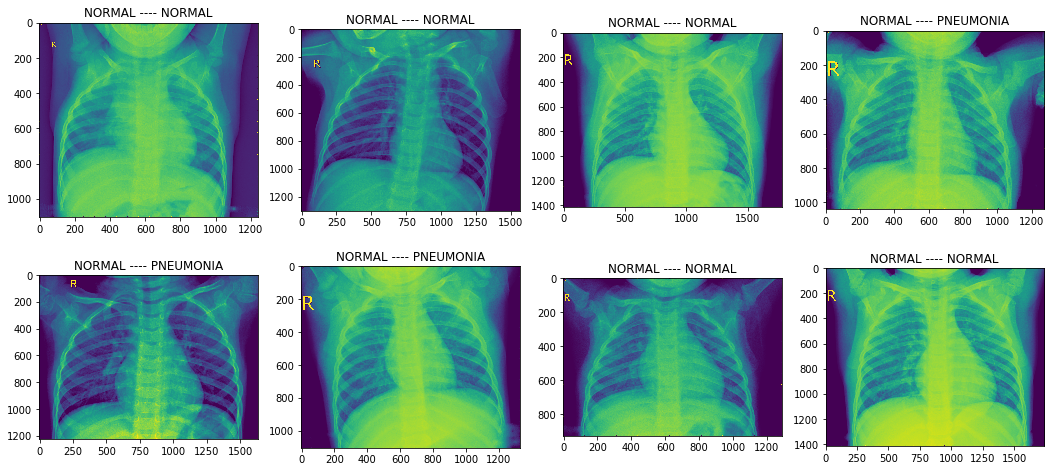

In [41]:
predict_images('./chest_xray/val/NORMAL', 'NORMAL')

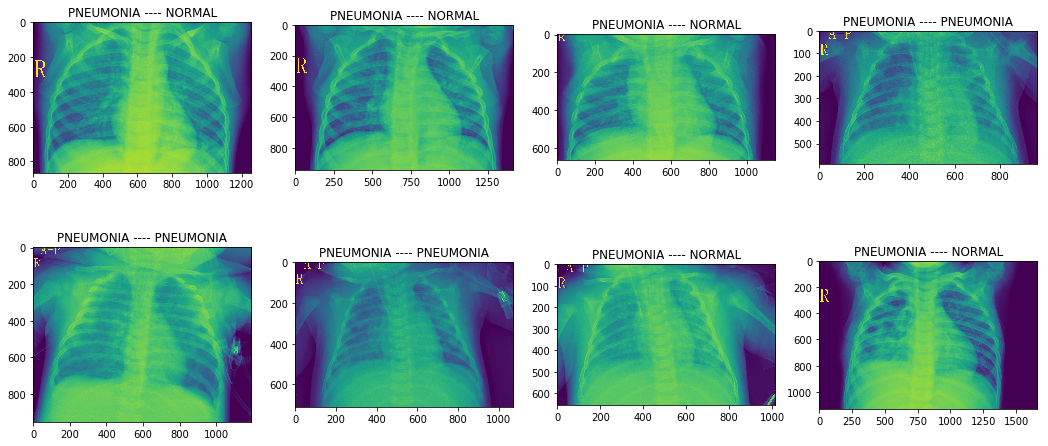

In [42]:
predict_images('./chest_xray/val/PNEUMONIA' , 'PNEUMONIA')